# Sistema de recomendación de libros basado en Filtrado colaborativo con Spark
**Presentado por Luis Hernando Benitez Criollo**

## Definición de la propuesta
Los sistemas de recomendación son implementaciones que se hicieron muy populares con la aparición de plataformas como netflix o gigantes del comercio electrónico como Amazon.
 
Estos sistemas son un subconjunto de algoritmos de filtrado que buscan predecir la calificación o los gustos de un usuario para un elemento que aún no conoce con el fin de recomendar aquellos que sean de su mayor interés.
 
Estas listas de recomendaciones se obtienen mediante dos técnicas: filtrado colaborativo y basado en contenido o recomendación cruzada.
 
**El filtrado colaborativo** Se basa en el comportamiento pasado del usuario. Analiza los gustos, calificaciones y decisiones de los usuarios y los agrupa, entonces para un usuario se recomiendan los elementos que han gustado a usuarios similares pero que este aún no ha consumido. Este filtro genera recomendaciones más diversas y no solo del tipo que se consume habitualmente
 
El **filtrado colaborativo basado en contenido** toma como base el elemento y sus características, se tiene en cuenta el comportamiento pasado del usuario (sin dar importancia a las opiniones de otros usuarios) así se obtienen recomendaciones de elementos similares pero menos diversas.
 
La **recomendación cruzada** toma como base las características del elemento y recomienda aquellos que comparten características similares, sin tener en cuenta opiniones personales o de terceros. 
 
### Problemática a resolver
Para el desarrollo de este taller abordaremos un caso hipotético en el cual el servicio de lectura de libros online “BookFlix” requiere implementar un servicio de recomendaciones para sus usuarios que les permita conocer nuevos libros según sus gustos y mejorar el enganche de la plataforma.
 
Para ello contamos con las bases de datos de calificaciones otorgadas por los usuarios
 
### Metodología.
El proyecto se aborda a través de la metodología CRISP-DM en la cual se presenta una fase de entendimiento del negocio, se exploran los datos, se hace el preprocesamiento necesario y se itera sobre el modelado y evaluación hasta lograr un resultado efectivo.
 
Esto se abordará a través de las tecnologías de bases de datos distribuidas Apache Spark y sus librerías de machine learning bajo el lenguaje de programación Python


## Declaración del conjunto de datos.
**goodbooks-10k**
El conjunto de datos a utilizar es de acceso público y se encuentra aquí: https://www.kaggle.com/zygmunt/goodbooks-10k
 
La descripción original: 
 
_Este conjunto de datos contiene clasificaciones de diez mil libros populares. En cuanto a la fuente, digamos que estas calificaciones se encontraron en Internet. En general, hay 100 reseñas para cada libro, aunque algunas tienen menos calificaciones. Las calificaciones van de uno a cinco.‎
‎Tanto los ID de libro como los ID de usuario son contiguos. Para los libros, son 1-10000, para los usuarios, 1-53424. Todos los usuarios han realizado al menos dos valoraciones. El número medio de clasificaciones por usuario es de 8.‎
‎También hay libros marcados para leer por los usuarios, metadatos de libros (autor, año, etc.) y etiquetas.‎_

Está compuesto por 4 subconjuntos de datos que se describen a continuación:
* **‎ratings.csv** contiene las calificaciones (columnas: book_id,user_id,rating)
* **‎toread.csv**‎‎ ‎‎ proporciona identificadores de los libros marcados como "para leer" por cada usuario, como pares ‎‎de id de usuario, book_id‎
* **books.csv**‎‎ tiene metadatos para cada libro (identificadores de goodreads, autores, título, calificación promedio, etc.).‎
* **‎book_tags.csv**‎‎ contiene etiquetas,géneros asignados por los usuarios a los libros. Las etiquetas de este archivo se representan mediante sus IDs.‎


## Definición de las tecnologías a implementar y justificación
El proyecto se abordará mediante las tecnologías Apache Spark y Python (implementación con pySpark)
 
Apache Spark es un framework para computación mediante clusters que permite manipular grandes cantidades de datos de manera eficiente y bajo una arquitectura distribuida, su uso se justifica en su facilidad de implementación con Python mediante la librería PySpark y en la necesidad de procesar 10 mil reseñas de libros de manera eficiente
 
Apache Spark no solo permite manejar grandes volúmenes de datos, también integra una poderosa librería de machine learning capaz de crear modelos de predicción eficientes.
 
En particular se utilizará el algoritmo de filtrado colaborativo ALS (mínimos cuadrados alternos)en este _los usuarios y los productos se describen mediante un pequeño conjunto de factores latentes que se pueden utilizar para predecir las entradas que faltan_ 
 
En palabras simples: _si tienes un amigo al que le gustan libros similares al tuyo quizá te interesen libros que tu amigo ha leído pero tú aún no conoces._
 
La implementación de estas tecnologías, además de ser pertinente permite poner en práctica los conocimientos adquiridos en el curso


### Descripcion de los datos
A continuación se realiza la descripción y exploración inicial de los datos

In [ ]:
# Instalacion del  OpenJDK 8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
# Configuracion de  la variable de entorno de Java.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
# Instalacion de paquetes PySpark
!pip install -q pyspark
!pip install -q findspark

In [ ]:
import pyspark#lib Spark
import numpy as np
import pandas as pd
import matplotlib as mpl
# Contexto de Spark para operaciones SQL y en DataFrame.
from pyspark.sql import SQLContext
# Objeto fila de una tabla SQL.
from pyspark.sql import Row

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
# Declaramos el contexto de Apache Spark
sc = pyspark.SparkContext()
spark = SQLContext(sc)#para operaciones SQL y con DataFrame

### to_read
Contiene el user_id y el book_id

In [ ]:
to_read_location = "/content/drive/MyDrive/UNAL/DiplomadoML/modulo 3 - BigData/06-ProyectoAplicado/Desarrollo/books-bd/to_read.csv"

#opciones solo para formato csv
to_read = spark.read.format('csv').option("inferSchema", 'True').option("header", 'True').option("sep", ',').load(to_read_location)

display(to_read)

# Crear tablas temporales
to_read.createOrReplaceTempView("to_read")

DataFrame[user_id: int, book_id: int]

In [ ]:
to_read.show()

+-------+-------+
|user_id|book_id|
+-------+-------+
|      1|    112|
|      1|    235|
|      1|    533|
|      1|   1198|
|      1|   1874|
|      1|   2058|
|      1|   3334|
|      2|      4|
|      2|     11|
|      2|     13|
|      2|     16|
|      2|     92|
|      2|    106|
|      2|    113|
|      2|    233|
|      2|    247|
|      2|    380|
|      2|    408|
|      2|    439|
|      2|    479|
+-------+-------+
only showing top 20 rows



In [ ]:
type(to_read)

pyspark.sql.dataframe.DataFrame

In [ ]:
# Convertimos el DataFrame de Spark en un DataFrame de Pandas.
pd_to_read = to_read.toPandas()
pd_to_read

,user_id,book_id
0,1,112
1,1,235
2,1,533
3,1,1198
4,1,1874
...,...,...
912700,53424,4716
912701,53424,4844
912702,53424,5907
912703,53424,7569


In [ ]:
pd_to_read.shape

(912705, 2)

In [ ]:
pd_to_read['user_id'].isna().sum()

0

In [ ]:
pd_to_read['book_id'].isna().sum()

0

Tenemos un total de 912705 libros que fueron guardados para leer despues por los usuarios, sin elementos nulos

### ratings

In [ ]:
#import ratings data
ratings_location = "/content/drive/MyDrive/UNAL/DiplomadoML/modulo 3 - BigData/06-ProyectoAplicado/Desarrollo/books-bd/ratings.csv"

ratings = spark.read.format('csv').option("inferSchema", 'True').option("header", 'True').option("sep", ',').load(ratings_location)

display(ratings)

ratings.createOrReplaceTempView("ratings")

DataFrame[book_id: int, user_id: int, rating: int]

In [ ]:
ratings_pd = ratings.toPandas()
ratings_pd

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4
...,...,...,...
981751,10000,48386,5
981752,10000,49007,4
981753,10000,49383,5
981754,10000,50124,5


In [ ]:
ratings_pd['rating'].describe()

count    981756.000000
mean          3.856534
std           0.983941
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

In [ ]:
ratings_pd['rating'].value_counts(dropna=False)

4    357366
5    292961
3    248623
2     63231
1     19575
Name: rating, dtype: int64

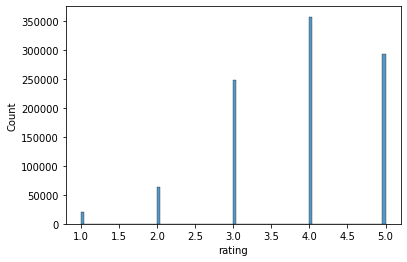

In [ ]:
sns.histplot(data=ratings_pd, x="rating")

La calificación más común es 4  y el promedio de todas las calificaciones se ubica cerca del 3.8
Todas las calificaciones son enteros. Con un total de 981756 calificaciones

### books

In [ ]:
books_location = "/content/drive/MyDrive/UNAL/DiplomadoML/modulo 3 - BigData/06-ProyectoAplicado/Desarrollo/books-bd/books.csv"
file_type = "csv"

books = spark.read.format('csv').option("inferSchema", 'True').option("header", 'True').option("sep", ',').load(books_location)

display(books)

books.createOrReplaceTempView("books")

DataFrame[id: int, book_id: int, best_book_id: int, work_id: int, books_count: int, isbn: string, isbn13: double, authors: string, original_publication_year: double, original_title: string, title: string, language_code: string, average_rating: string, ratings_count: string, work_ratings_count: string, work_text_reviews_count: string, ratings_1: double, ratings_2: int, ratings_3: int, ratings_4: int, ratings_5: int, image_url: string, small_image_url: string]

In [ ]:
books_pd = books.toPandas()
books_pd.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715.0,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504.0,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191.0,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427.0,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236.0,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [ ]:
books_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         10000 non-null  int32  
 1   book_id                    10000 non-null  int32  
 2   best_book_id               10000 non-null  int32  
 3   work_id                    10000 non-null  int32  
 4   books_count                10000 non-null  int32  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  object 
 13  ratings_count              10000 non-null  obje

In [ ]:
books_pd.shape

(10000, 23)

Un total de 10000 libros, a continuación limpiamos la variable 'ratings_count ' que esta formateada como string al igual que 'average_rating'

In [ ]:
books_pd = books_pd[books_pd['ratings_count'].str.isdigit() == True]#algunos valores NO son numericos, se descartan
books_pd['ratings_count'] = books_pd['ratings_count'].astype('int')

In [ ]:
books_pd['average_rating'] = books_pd['average_rating'].astype('float')

#### Los 10 libros mas calificados

In [ ]:
books_pd.sort_values(by = 'ratings_count', ascending = False)[['original_title','authors','original_publication_year','ratings_count', 'average_rating' ]][0:10]

,original_title,authors,original_publication_year,ratings_count,average_rating
0,The Hunger Games,Suzanne Collins,2008.0,4780653,4.34
1,Harry Potter and the Philosopher's Stone,"J.K. Rowling, Mary GrandPré",1997.0,4602479,4.44
2,Twilight,Stephenie Meyer,2005.0,3866839,3.57
3,To Kill a Mockingbird,Harper Lee,1960.0,3198671,4.25
4,The Great Gatsby,F. Scott Fitzgerald,1925.0,2683664,3.89
5,The Fault in Our Stars,John Green,2012.0,2346404,4.26
6,The Hobbit or There and Back Again,J.R.R. Tolkien,1937.0,2071616,4.25
7,The Catcher in the Rye,J.D. Salinger,1951.0,2044241,3.79
9,Pride and Prejudice,Jane Austen,1813.0,2035490,4.24
8,Angels & Demons,Dan Brown,2000.0,2001311,3.85


Resulta curioso que el libro mas reciente en el top-10 sea el mas calificado por los usuarios

#### Top 10 libros con mayor puntaje

In [ ]:
#revisamos los libros con mayor puntaje promedio
books_pd.sort_values(by = 'average_rating', ascending = False)[['original_title','authors','original_publication_year','ratings_count', 'average_rating' ]][0:10]

,original_title,authors,original_publication_year,ratings_count,average_rating
3627,The Complete Calvin and Hobbes,Bill Watterson,2005.0,28900,4.82
861,Words of Radiance,Brandon Sanderson,2014.0,73572,4.77
3274,None,"J.K. Rowling, Mary GrandPré",2003.0,33220,4.77
8853,Mark of the Lion Trilogy,Francine Rivers,1993.0,9081,4.76
7946,None,"Anonymous, Lane T. Dennis, Wayne A. Grudem",2002.0,8953,4.76
4482,It's a Magical World: A Calvin and Hobbes Coll...,Bill Watterson,1996.0,22351,4.75
6360,There's Treasure Everywhere: A Calvin and Hobb...,Bill Watterson,1996.0,16766,4.74
421,Complete Harry Potter Boxed Set,J.K. Rowling,1998.0,190050,4.74
6589,The Authoritative Calvin and Hobbes,Bill Watterson,1990.0,16087,4.73
6919,The Indispensable Calvin and Hobbes: A Calvin ...,Bill Watterson,1992.0,14597,4.73


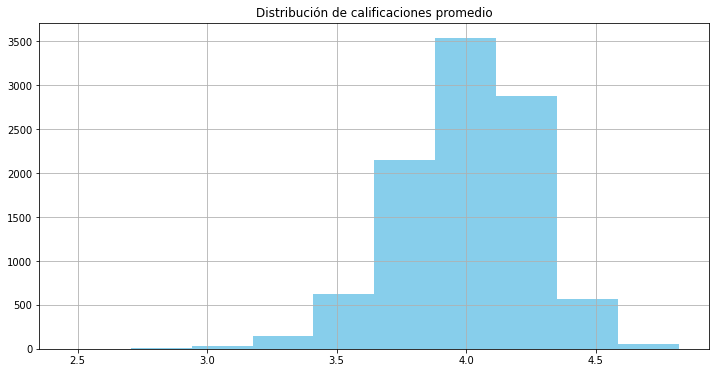

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Distribución de calificaciones promedio')
books_pd['average_rating'].hist(color='skyblue', histtype='bar')
plt.show()

Hay dos libros sin informacion de titulo entre el top-10 de los mejor puntuados. Las calificaciones se ubican en su mayoria en valores de 3.8 a 4.2

#### Top-10 los autores con mas publicaciones

In [ ]:
autores_mas_books = pd.DataFrame(books_pd['authors'].value_counts()[0:10]).reset_index()
autores_mas_books.columns = ['author', 'number_of_books']

In [ ]:
autores_mas_books

,author,number_of_books
0,Stephen King,60
1,Nora Roberts,59
2,Dean Koontz,47
3,Terry Pratchett,42
4,Agatha Christie,39
5,Meg Cabot,37
6,James Patterson,36
7,David Baldacci,34
8,John Grisham,33
9,J.D. Robb,33


### Exploracion de los ratings y libros

In [ ]:
ratings_pd.groupby(['book_id']).count()

,user_id,rating
book_id,,
1,100,100
2,100,100
3,100,100
4,100,100
5,100,100
...,...,...
9996,98,98
9997,89,89
9998,95,95


Algunos libros tienen menos de 100 calificaciones en el dataset de ratings. Veamos si hay libros con menos calificaciones

In [ ]:
ratings_pd.groupby(['book_id']).count().sort_values(by = 'rating', ascending = True)

,user_id,rating
book_id,,
7803,8,8
9345,11,11
9486,24,24
1935,34,34
9315,36,36
...,...,...
3311,100,100
3312,100,100
3313,100,100


El libro con menos calificaicones tiene 8, no hay elementos con 0's

In [ ]:
# usuarios que mas puntuan
(ratings.groupBy("user_id")
    .count()
    .filter("`count` >= 5")
    .orderBy('count', ascending=False)
    .show(n = 10))

+-------+-----+
|user_id|count|
+-------+-----+
|  12874|  200|
|  30944|  200|
|  28158|  199|
|  12381|  199|
|  52036|  199|
|   6630|  197|
|  37834|  197|
|  45554|  197|
|   9806|  196|
|  19729|  196|
+-------+-----+
only showing top 10 rows



Podemos notar que los libros más calificados en books.csv no corresponden a los libros más calificados en ratings.csv

## Implementación de modelo machine learning
Recordemos el método de filtrado colaborativo con un ejemplo muy simple:
“Si tienes un amigo con gustos similares que tu, por ejemplo las peliculas de accion. Es muy probable que quieras ver una película que le gusto a tu amigo pero tu aun no conoces”
 
El método de mínimos cuadrados alternados ELA utiliza las calificaciones de todos los usuarios para predecir las preferencias de cada uno en particular. En palabras simples se busca rellenar los datos faltantes de la matriz, intentando predecir qué puntaje le dará el usuario a un libro que no conoce. Si el puntaje predicho es lo suficientemente alto, se le recomendará
 
_se intenta encontrar la función continua, dentro de dicha familia, que mejor se aproxime a los datos (un "mejor ajuste"), de acuerdo con el criterio de **mínimo error cuadrático.**_
 
_intenta minimizar la suma de cuadrados de las diferencias en las ordenadas (llamadas residuos) entre los puntos generados por la función elegida y los correspondientes valores en los datos._

https://es.wikipedia.org/wiki/M%C3%ADnimos_cuadrados

In [ ]:
#importamos las librerias necesarias
from pyspark.ml.evaluation import RegressionEvaluator #para evaluar los resultados 
from pyspark.ml.recommendation import ALS #modelo de ML basado en la recomendacion colaborativa

La implementación del algoritmo ALS a través de Spark recibe los siguientes parámetros:
* **umBlocks** Es el número de bloques para usar computación paralela. No lo especificaremos, pues la implementación se hace de manera local
 
* **implicitPrefs** se define como **False** para especificar que usamos datos implícitos
 
* **coldStartStrategy** específica que pueden no haber datos para algún usuario y evita las predicciones nulas

* **regParam‎‎** especifica el parámetro de regularización en ALS (el valor predeterminado es 1.0)‎

* **‎rank**‎‎ es el número de entidades que se va a utilizar (también denominado número de factores latentes).‎

 
y otros más intuitivos como el userCol, itemCol, ratingCol, nonnegative que impide predicciones con valores menores que 0 y iterations (tipicamente en 20)

https://spark.apache.org/docs/latest/mllib-collaborative-filtering.html#collaborative-filtering


In [ ]:
als = ALS( userCol="user_id", itemCol="book_id", ratingCol="rating",
          coldStartStrategy="drop", nonnegative = True, implicitPrefs = False)

Am continuación definimos una parrilla de hiperparametros a probar mediante la validación cruzada

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator 

param_grid = ParamGridBuilder().addGrid(als.rank, [10, 20, 50, 75, 100]).addGrid(als.maxIter, [5, 20, 50, 75, 100]).addGrid(als.regParam, [.01, .05, .1, .15]).build()

Se realizara un total de 100 modelos. Veremos que tan rapido es Spark capaz de procesar esto

In [ ]:
# Definir el evaluador RMSE (error cuadratico medio)
evaluador = RegressionEvaluator(metricName = "rmse", 
                                labelCol = "rating", 
                                predictionCol = "prediction")
print ("Numero de modelos a testear: ", len(param_grid))

Numero de modelos a testear:  100


In [ ]:
#definimos los datos de entrenamiento 80% y validacion 20%
(train, test) = ratings.randomSplit([0.8, 0.2])

In [ ]:
train.count()

785298

In [ ]:
# definimos la validacion cruzada
cv = CrossValidator(estimator = als, 
                    estimatorParamMaps = param_grid, 
                    evaluator = evaluador, 
                    numFolds = 5)

In [ ]:
time_start = datetime.now()
model = als.fit(train)
time_end = datetime.now()
final_time = time_end - time_start

In [ ]:
final_time

datetime.timedelta(seconds=27, microseconds=900369)

In [ ]:
model

ALSModel: uid=ALS_d59c6d2e4e6d, rank=10

Se entrenaron 100 modelos con 785671 datos mediante validacion cruzada en menos de 25 segundos

In [ ]:
test.show()

+-------+-------+------+
|book_id|user_id|rating|
+-------+-------+------+
|      1|    314|     5|
|      1|   2077|     4|
|      1|   2487|     4|
|      1|   3662|     4|
|      1|   5885|     5|
|      1|  17434|     5|
|      1|  20848|     5|
|      1|  21713|     5|
|      1|  24326|     5|
|      1|  24389|     4|
|      1|  24499|     5|
|      1|  24845|     5|
|      1|  26629|     4|
|      1|  31001|     4|
|      1|  32923|     5|
|      1|  37834|     5|
|      1|  51480|     1|
|      1|  51838|     5|
|      1|  53245|     4|
|      2|   3922|     5|
+-------+-------+------+
only showing top 20 rows



Los datos con los que se entrena el modelo son el id del libro, el id de usuario y la calificacion que dio a el libro

In [ ]:
predictions = model.transform(test) #obtenemos las predicciones

In [ ]:
predictions.show(n = 20)

+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|    148|  20467|     3|  2.870829|
|    148|    588|     4|  3.358562|
|    148|  10727|     4| 3.2160969|
|    148|  26629|     4| 3.8681252|
|    148|  13034|     4| 3.4748938|
|    148|  10610|     4| 3.8193178|
|    148|  33065|     3| 3.5901222|
|    148|  18313|     4|  3.355578|
|    148|  27934|     4|  3.214049|
|    148|   8579|     3| 2.9668822|
|    148|  11272|     3| 3.0618773|
|    148|  51166|     4| 3.7735682|
|    148|  24499|     4|  2.933656|
|    148|  39618|     3|  3.384084|
|    148|  44397|     5|  4.144354|
|    148|  47730|     2| 3.6327515|
|    148|  10335|     3|  3.443533|
|    148|  23612|     4|  3.213006|
|    148|  34688|     4| 2.9721162|
|    148|   2487|     2| 3.0389705|
+-------+-------+------+----------+
only showing top 20 rows



Las predicciones sobre el conjunto de prueba son buenas y se acercan al valor real. Por ejemplo para el usuario 39618 la calificación original fue de 3 y la predicción de 3.38 .
 
En otros casos, para el usuario 34688 el valor original es de 5 y la predicción de 2.97 un poco alejada.

In [ ]:
#creamos una vista para las predicciones
predictions.createOrReplaceTempView("predictions")

In [ ]:
consult = spark.sql(""" select predictions.user_id, predictions.book_id, predictions.rating, predictions.prediction, 
books.title from predictions inner join books ON predictions.book_id = books.id """)

In [ ]:
consult.show()

+-------+-------+------+----------+--------------------+
|user_id|book_id|rating|prediction|               title|
+-------+-------+------+----------+--------------------+
|  20467|    148|     3|  2.870829|Girl with a Pearl...|
|    588|    148|     4|  3.358562|Girl with a Pearl...|
|  10727|    148|     4| 3.2160969|Girl with a Pearl...|
|  26629|    148|     4| 3.8681252|Girl with a Pearl...|
|  13034|    148|     4| 3.4748938|Girl with a Pearl...|
|  10610|    148|     4| 3.8193178|Girl with a Pearl...|
|  33065|    148|     3| 3.5901222|Girl with a Pearl...|
|  18313|    148|     4|  3.355578|Girl with a Pearl...|
|  27934|    148|     4|  3.214049|Girl with a Pearl...|
|   8579|    148|     3| 2.9668822|Girl with a Pearl...|
|  11272|    148|     3| 3.0618773|Girl with a Pearl...|
|  51166|    148|     4| 3.7735682|Girl with a Pearl...|
|  24499|    148|     4|  2.933656|Girl with a Pearl...|
|  39618|    148|     3|  3.384084|Girl with a Pearl...|
|  44397|    148|     5|  4.144

A continuación calculemos el error entre los valores reales y predichos

In [ ]:
rmse = evaluador.evaluate(predictions)
print("Raiz del error cuadrado medio RMSE = " + str(rmse))

Raiz del error cuadrado medio RMSE = 0.9207267604579371


Tenemos un RMSE de 0.9, casi de 1. No es realmente un muy buen valor teniendo en cuenta los rangos de calificacion de 1 a 5.

## Generamos recomendaciones para todos los usuarios

In [ ]:
recomendaciones = model.recommendForAllUsers(numItems = 5)#genera 5 recomendaciones para cada usuario

In [ ]:
recomendaciones.show()

+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|    148|[{4868, 4.642585}...|
|    463|[{8913, 4.9087353...|
|    471|[{7154, 3.584676}...|
|    496|[{9842, 5.7305083...|
|    833|[{5344, 5.341319}...|
|   1088|[{8233, 4.6502237...|
|   1238|[{721, 4.740133},...|
|   1342|[{4522, 4.849815}...|
|   1580|[{4868, 5.365266}...|
|   1591|[{4154, 5.5630307...|
|   1645|[{9182, 4.6641755...|
|   1829|[{1788, 4.819388}...|
|   1959|[{5344, 3.5244126...|
|   2122|[{1183, 4.93258},...|
|   2142|[{8233, 4.8993373...|
|   2366|[{8415, 5.8794036...|
|   2659|[{7081, 4.5085764...|
|   2866|[{4638, 4.801195}...|
|   3175|[{3282, 4.6535134...|
|   3749|[{9842, 4.0159993...|
+-------+--------------------+
only showing top 20 rows



In [ ]:
recomendaciones.registerTempTable("ALS_recom_temp")

In [ ]:
#sacamos las recomendaciones del arreglo devuelto
full_recomendaciones = spark.sql("""SELECT user_id,
                            bookIds_and_ratings.book_id AS book_id,
                            bookIds_and_ratings.rating AS prediction
                        FROM ALS_recom_temp
                        LATERAL VIEW explode(recommendations) exploded_table
                            AS bookIds_and_ratings""")
full_recomendaciones.show()

+-------+-------+----------+
|user_id|book_id|prediction|
+-------+-------+----------+
|    148|   4868|  4.642585|
|    148|   3491| 4.5137663|
|    148|   9842| 4.4881244|
|    148|   5207|   4.46648|
|    148|   2840| 4.4318395|
|    463|   8913| 4.9087353|
|    463|   2507|   4.86413|
|    463|   7401| 4.8443627|
|    463|   8333| 4.8197575|
|    463|   4969| 4.8100405|
|    471|   7154|  3.584676|
|    471|   9831| 3.5743787|
|    471|   3773| 3.5419402|
|    471|   2071| 3.5392482|
|    471|   6784| 3.5144017|
|    496|   9842| 5.7305083|
|    496|   8233|   5.62523|
|    496|   9076| 5.5936356|
|    496|   8187| 5.5508556|
|    496|   3753|  5.500046|
+-------+-------+----------+
only showing top 20 rows



In [ ]:
#recomendacioens para libros no leidos (cuyo rating es 0)
new_books = (full_recomendaciones.join(ratings, ["user_id", "book_id"], "left").filter(ratings.rating.isNull()))

In [ ]:
new_books.count()

259389

Obtuvimos 260073 recomendaciones (5 para cada usuario)

In [ ]:
new_books.show()

+-------+-------+----------+------+
|user_id|book_id|prediction|rating|
+-------+-------+----------+------+
|     20|   7790|  5.034674|  null|
|    149|   1338| 5.0446515|  null|
|    159|   4054|  4.076024|  null|
|    165|   1628| 3.7979631|  null|
|    172|   5202| 4.9052863|  null|
|    215|   8913|  4.689016|  null|
|    224|   7165|  5.537496|  null|
|    243|   5420|  4.701738|  null|
|    317|   3224| 1.0431457|  null|
|    355|   8109|  5.117899|  null|
|    365|   3917|  5.591592|  null|
|    376|   2636| 5.0117135|  null|
|    396|   6425| 4.4109693|  null|
|    436|   5335| 4.5128574|  null|
|    546|   2151| 4.6868806|  null|
|    572|   4643| 3.4558706|  null|
|    578|   8926| 4.9147997|  null|
|    584|   7282| 4.8039412|  null|
|    612|   5753|  4.903419|  null|
|    650|   9461| 5.3014283|  null|
+-------+-------+----------+------+
only showing top 20 rows



## Libros recomendados y libros en "no leidos"
Existe una relación entre los libros guardados en “to_read” y los libros recomendados. Deberiamos encontrar algunos libros de “to_read” como recomendaciones para los usuarios.
 
Veamos cuantos tenemos


In [ ]:
to_read.createOrReplaceTempView("to_read")

In [ ]:
to_read.count()

912705

In [ ]:
join_reco_toread = new_books.join(to_read,
                              on = ["user_id", "book_id"], 
                              how = "inner")
join_reco_toread.show()

+-------+-------+----------+------+
|user_id|book_id|prediction|rating|
+-------+-------+----------+------+
|  34876|   9842|  4.941967|  null|
|    761|   6971| 3.2674494|  null|
|  25330|   1328| 4.7931294|  null|
|  49627|   9876| 4.6897774|  null|
|  50361|   4264| 3.6696973|  null|
|   5843|   7988| 2.8548403|  null|
|  15178|    189| 4.2297444|  null|
|  33940|   7939| 3.8167925|  null|
|  41703|   1788| 4.1333804|  null|
|  22508|   1010| 3.6071625|  null|
|  15869|   5849|  5.234683|  null|
|  14760|   9842|   5.10773|  null|
|  36500|    862| 5.5804973|  null|
|   1071|   2831|  5.041994|  null|
|   9745|   1728| 3.3467226|  null|
|  32121|   1577| 5.2252975|  null|
|   2155|   1499|  4.313002|  null|
|  20128|    464| 4.5965967|  null|
|  22250|     10| 4.7470074|  null|
|   2064|    983|  4.616926|  null|
+-------+-------+----------+------+
only showing top 20 rows



In [ ]:
join_reco_toread.count()

360

## Conclusiones finales
 
Los resultados de la predicción no fueron los mejores. El error cuadrado medio o RMSE es alto para un rango de valores tan pequeño, llegando a tener una diferencia de hasta +1 de los datos originales de rating respecto a los valores predichos.
 
El algoritmo de machine learning ALS de Spark resulta eficiente y es capaz de entrenarse en muy poco tiempo con buenos resultados, sin bien los resultados son mejorables el algoritmo es una muy buena opción para abordar los problemas de recomendación y se propone seguir iterando sobre nuevos hiperparametros y con una exploración más profunda de la calidad de los datos.
 
Solo se lograron 360 coincidencias de valores predichos y que los usuarios habían guardado en su lista to_read. En otras ejecuciones (el algoritmo de entrenamiento se ejecuta sin una semilla) los valores oscilan entre 408 y 248.
 
Spark (con pyspark) es una librería eficiente y completa para abordar problemas de computación distribuida, es capaz de manejar grandes cantidades de datos y procesar información mediante técnicas de machine learning con uno o varios clusters, aprovechando al máximo los recursos de la máquina con buenos resultados.
